## Trabajo aprendizaje supervisado:
* Se retoma el modelo lgb anterior y se realiza smote oversampling sobre la variable de salida y se analizan los resultados sin la data afectada en entrenamiento. 
* Stiven Cadavid Cataño

* Objetivo: Se requiere un modelo que ayude a identificar la posible fuga de clientes en una empresas de telecomunicaciones donde se espera identificarlos para ajustarles una oferta que se ajsute a sus necesidades y permanezca en la compañia dado que el eslogan de la compañia es que cuesta 7 veces más adquirir un cliente nuevo que reter a uno.

Se espera encotrar un modelo supervisado que logre identificar en su mayoria los clientes que se van dejar la compañia dado que el costo de adquisición es más alto, por tanto, el negocio prefiere brindarle una oferta de retención así no tenga incentivos a retirarse es decir acpeta o tiene cierta tolerancia con aquellos que el modelo predice como churn y en realidad no lo son y si exige mayor cautela con aquellos que no son clasificadods como churn y si se van.

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from scipy.stats import norm, skew
from scipy import stats
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import os
import warnings
import pingouin as pg
from utils.funciones import multiple_plot
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
import joblib
from sklearn.metrics import f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE


Descripciones de las Variables:
* customerID: ID del cliente.
* gender: género del cliente (Masculino/Femenino).
* seniorCitizen: indica si el cliente es un ciudadano senior (1/0).
* partner: indica si el cliente tiene pareja (Sí/No).
* dependents: indica si el cliente tiene dependientes (Sí/No).
* tenure: número de meses que el cliente ha estado con la compañía.
* phoneService: indica si el cliente tiene servicio telefónico (Sí/No).
* multipleLines: indica si el cliente tiene múltiples líneas (Sí/No/Sin servicio telefónico).
* internetService: proveedor de servicio de internet del cliente (DSL/Fibra óptica/No).
* onlineSecurity: indica si el cliente tiene seguridad en línea (Sí/No/Sin servicio de internet).
* onlineBackup: indica si el cliente tiene respaldo en línea (Sí/No/Sin servicio de internet).
* deviceProtection: indica si el cliente tiene protección de dispositivos (Sí/No/Sin servicio de internet).
* techSupport: indica si el cliente tiene soporte técnico (Sí/No/Sin servicio de internet).
* streamingTV: indica si el cliente tiene servicio de TV por streaming (Sí/No/Sin servicio de internet).
* streamingMovies: indica si el cliente tiene servicio de películas por streaming (Sí/No/Sin servicio de internet).
* contract: término del contrato del cliente (Mes a mes/Un año/Dos años).
* paperlessBilling: indica si el cliente tiene facturación sin papeles (Sí/No).
* paymentMethod: método de pago del cliente (Cheque electrónico/Cheque enviado/Transferencia bancaria automática/Tarjeta de crédito automática).
* monthlyCharges: cantidad cobrada al cliente mensualmente.
* totalCharges: cantidad total cobrada al cliente.
* churn: indica si el cliente se dio de baja de la compañia (Sí/No).

In [25]:
os.getcwd()

'd:\\Desktop\\Camino a la U Again\\clase_ml\\classification'

## Lectura

In [33]:
# Reading the datasets from CSV files
X_train = pd.read_csv('objetos/datasets/X_train.csv')
X_test = pd.read_csv('objetos/datasets/X_test.csv')
X_val = pd.read_csv('objetos/datasets/X_val.csv')
y_train = pd.read_csv('objetos/datasets/y_train.csv')['Churn']
y_test = pd.read_csv('objetos/datasets/y_test.csv')['Churn']
y_val = pd.read_csv('objetos/datasets/y_val.csv')['Churn']

## Funciones

In [50]:
def apply_threshold(probas, threshold):
    return (probas >= threshold).astype(int)

def find_best_threshold(model, X, y):
    # Predict probabilities
    probas = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probas)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_index = np.argmax(f1_scores)
    # Esto me va a devolver el máximo f1
    return thresholds[max_index], f1_scores[max_index]

### Se van a realizar busqueda de hiperparametros tratando de maximizar el AUC.
para el mejor modelo anterior, buscando mejorar su perfomance, el cual vamos a importar:

In [35]:
lgb_model = joblib.load('objetos/LightGBM_model.joblib')

In [36]:
lgb_model

LGBMClassifier(learning_rate=0.010799121952637642, max_depth=13,
               n_estimators=198, num_leaves=21)

### Esto nos permite identificar la capacidad de generalziación del modelo y evitar el sobre ajuste.

In [84]:
## Evaluación del modelo en x_test
y_pred_proba_lgb = lgb_model.predict_proba(X_train)[:, 1]
best_threshold = 0.38520930434560685  # As noted from your previous analysis
y_pred_lgb = (y_pred_proba_lgb > best_threshold).astype(int)
auc_lgb = roc_auc_score(y_train, y_pred_proba_lgb)
print(f"ROC AUC Score for LightGBM: {auc_lgb}")
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_train, y_pred_lgb).ravel()

ROC AUC Score for LightGBM: 0.8795491080420579


In [85]:
## Evaluación del modelo en x_test
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
best_threshold = 0.38520930434560685  # As noted from your previous analysis
y_pred_lgb = (y_pred_proba_lgb > best_threshold).astype(int)
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
print(f"ROC AUC Score for LightGBM: {auc_lgb}")
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_test, y_pred_lgb).ravel()


ROC AUC Score for LightGBM: 0.8546965879015516


In [86]:
## Evaluación del modelo en x_val
y_pred_proba_lgb_val = lgb_model.predict_proba(X_val)[:, 1]
best_threshold = 0.38520930434560685  # As noted from your previous analysis
y_pred_lgb_val = (y_pred_proba_lgb_val > best_threshold).astype(int)
auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb_val)
print(f"ROC AUC Score for LightGBM: {auc_lgb}")
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_val, y_pred_lgb_val).ravel()

ROC AUC Score for LightGBM: 0.8484660711015773


## Con ayuda de optuna buscaremos realizar una validación cruzada para lograr mejorar los resultados del modelo anterior y mejorar la gwneralización.

In [94]:
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', -1, 15)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 1, 20)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 10, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.0)

    classifier = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )
    score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score
study_lgbm = optuna.create_study(direction='maximize', study_name='LiGHT')
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-05-03 20:36:45,707] A new study created in memory with name: LiGHT
[I 2024-05-03 20:36:46,087] Trial 0 finished with value: 0.836768626632866 and parameters: {'n_estimators': 132, 'max_depth': 15, 'learning_rate': 0.0453545633143206, 'num_leaves': 16, 'min_child_samples': 6, 'min_child_weight': 0.06833328483943678, 'reg_alpha': 12.71412923139312, 'reg_lambda': 0.4525312121411399}. Best is trial 0 with value: 0.836768626632866.
[I 2024-05-03 20:36:46,242] Trial 1 finished with value: 0.8353912072675765 and parameters: {'n_estimators': 106, 'max_depth': 10, 'learning_rate': 0.17549449758636176, 'num_leaves': 20, 'min_child_samples': 10, 'min_child_weight': 3.0931724855771088, 'reg_alpha': 19.937014726298056, 'reg_lambda': 0.23182195119833315}. Best is trial 0 with value: 0.836768626632866.
[I 2024-05-03 20:36:46,427] Trial 2 finished with value: 0.8376686701499498 and parameters: {'n_estimators': 138, 'max_depth': 14, 'learning_rate': 0.13555809576148042, 'num_leaves': 8, 'min_ch

In [95]:
lgb_model2 = LGBMClassifier(**study_lgbm.best_params)
lgb_model2.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.07388971759712734, max_depth=13,
               min_child_samples=99, min_child_weight=4.44063818637426,
               n_estimators=170, num_leaves=7, reg_alpha=13.830564001085941,
               reg_lambda=0.9890399424261587)

In [96]:
def find_best_threshold(model, X, y):
    # Predict probabilities
    probas = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probas)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    max_index = np.argmax(f1_scores)
    return thresholds[max_index], f1_scores[max_index]
models = {
    'LightGBM': lgb_model2,
}

best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")

Best threshold for LightGBM is 0.35258536830185094 with F1 Score: 0.6657496561210454


### Esto nos permite identificar la capacidad de generalziación del modelo y evitar el sobre ajuste.

In [97]:
y_pred_proba_lgb = lgb_model2.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)
auc_lgb = roc_auc_score(y_train, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_train, y_pred_lgb).ravel()
print(auc_lgb)

0.8547390985683794


In [98]:
y_pred_proba_lgb = lgb_model2.predict_proba(X_test)[:, 1]
y_pred_lgb = lgb_model.predict(X_test)
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_test, y_pred_lgb).ravel()
print(auc_lgb)

0.8582346788380166


In [99]:

y_pred_proba_lgb = lgb_model2.predict_proba(X_val)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)
auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_val, y_pred_lgb).ravel()
print(auc_lgb)

0.8528526957386141


In [100]:
cm = confusion_matrix(y_val, y_pred_lgb)

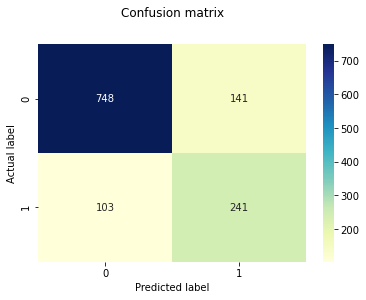

In [101]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
cm = confusion_matrix(y_val, y_pred_lgb)


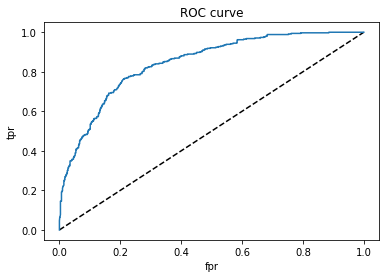

In [209]:
from sklearn.metrics import roc_curve
y_pred_proba = lgb_model2.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_lgb)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [104]:
### Ahora se refinará el ejercicio con SMOTE para tratar de identificar si se gana o no en performance condica metodologia

In [112]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)## Sólo voy a afectar el train, luego procedo a realizar CV y luego valido con mi fuera de muestra y mantengo lo demás constante

In [160]:
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', -1, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    num_leaves = trial.suggest_int('num_leaves', 20, 31)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 11, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 12, 20)

    classifier = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )
    score = cross_val_score(classifier, X, y, cv=5, scoring='roc_auc').mean()
    return score
study_lgbm = optuna.create_study(direction='maximize', study_name='LiGHT')
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-05-03 20:50:18,846] A new study created in memory with name: LiGHT
[I 2024-05-03 20:50:19,029] Trial 0 finished with value: 0.8607443976025898 and parameters: {'n_estimators': 142, 'max_depth': 1, 'learning_rate': 0.10609238494694545, 'num_leaves': 29, 'min_child_samples': 88, 'min_child_weight': 5.969665592491089, 'reg_alpha': 17.47783323897145, 'reg_lambda': 18.468837118755737}. Best is trial 0 with value: 0.8607443976025898.
[I 2024-05-03 20:50:19,190] Trial 1 finished with value: 0.8336402515404575 and parameters: {'n_estimators': 119, 'max_depth': 1, 'learning_rate': 0.01995678211763168, 'num_leaves': 22, 'min_child_samples': 83, 'min_child_weight': 9.38175022425259, 'reg_alpha': 13.574207072853422, 'reg_lambda': 12.410749748831476}. Best is trial 0 with value: 0.8607443976025898.
[I 2024-05-03 20:50:19,504] Trial 2 finished with value: 0.8725538830630652 and parameters: {'n_estimators': 123, 'max_depth': -1, 'learning_rate': 0.11302388398324333, 'num_leaves': 29, 'min_chi

In [161]:
lgb_model3 = LGBMClassifier(**study_lgbm.best_params)
lgb_model3.fit(X, y)

LGBMClassifier(learning_rate=0.14925754841022815, max_depth=0,
               min_child_samples=56, min_child_weight=0.8595545418543221,
               n_estimators=142, num_leaves=23, reg_alpha=11.188172359938008,
               reg_lambda=17.390994454270885)

In [193]:
models = {
    'LightGBM': lgb_model3,
}

In [194]:

best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")

Best threshold for LightGBM is 0.4294122693739029 with F1 Score: 0.646562123039807


In [195]:
y_pred_proba_lgb = lgb_model3.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)
auc_lgb = roc_auc_score(y_train, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_train, y_pred_lgb).ravel()
print(auc_lgb)

0.8692708943627401


In [196]:
y_pred_proba_lgb = lgb_model3.predict_proba(X_test)[:, 1]
y_pred_lgb = lgb_model.predict(X_test)
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_test, y_pred_lgb).ravel()
print(auc_lgb)

0.8394750426201004


In [197]:

y_pred_proba_lgb = lgb_model3.predict_proba(X_val)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)
auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_val, y_pred_lgb).ravel()
print(auc_lgb)

0.840315745415544


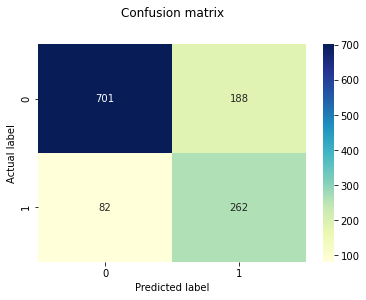

In [206]:


cm3 = confusion_matrix(y_val, y_pred_lgb)
p = sns.heatmap(pd.DataFrame(cm3), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
cm3 = confusion_matrix(y_val, y_pred_lgb)

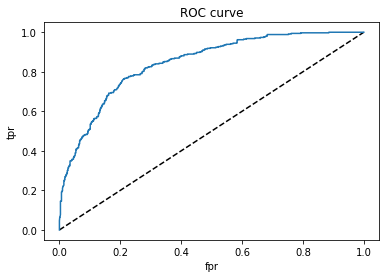

In [210]:
from sklearn.metrics import roc_curve
y_pred_proba = lgb_model3.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_lgb)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

## Save all

In [168]:
# Assuming models are stored in a dictionary like before
models = {
    'LightGBM': lgb_model3,
}

for name, model in models.items():
    joblib.dump(model, f'objetos/{name.replace(" ", "_")}_model.joblib')


In [169]:
import pandas as pd

X_train_df = pd.DataFrame(X)
y_train_df = pd.DataFrame(y)



In [170]:
# Save to CSV
X_train_df.to_csv('objetos/datasets/X_train_smote.csv', index=False)
y_train_df.to_csv('objetos/datasets/y_train_smote.csv', index=False)


### Para finalizar deseo realizar un ejercicio donde conn ayuda de optuna quiero apuntar a maximizar dos metricas importantes el AUC y la precisión

In [172]:
def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 150)
    max_depth = trial.suggest_int('max_depth', -1, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    num_leaves = trial.suggest_int('num_leaves', 20, 31)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0)
    reg_alpha = trial.suggest_float('reg_alpha', 11, 20)
    reg_lambda = trial.suggest_float('reg_lambda', 12, 20)

    classifier = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )

    scores = cross_validate(classifier, X, y, cv=5, scoring={'roc_auc': 'roc_auc', 'precision': 'precision'}, n_jobs=-1)
    mean_roc_auc = scores['test_roc_auc'].mean()
    mean_precision = scores['test_precision'].mean()
    return mean_roc_auc, mean_precision

study_lgbm = optuna.create_study(directions=['maximize', 'maximize'], study_name='LiGHT')
study_lgbm.optimize(objective_lgbm, n_trials=30)



[I 2024-05-03 20:52:45,569] A new study created in memory with name: LiGHT
[I 2024-05-03 20:52:46,918] Trial 0 finished with values: [0.8520379277260043, 0.731956822789793] and parameters: {'n_estimators': 146, 'max_depth': 2, 'learning_rate': 0.01618070586880396, 'num_leaves': 22, 'min_child_samples': 96, 'min_child_weight': 6.51596660510484, 'reg_alpha': 19.912027342816714, 'reg_lambda': 13.521722767453012}. 
[I 2024-05-03 20:52:47,942] Trial 1 finished with values: [0.869724654952282, 0.7612568507630738] and parameters: {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.04553308971063885, 'num_leaves': 23, 'min_child_samples': 91, 'min_child_weight': 5.437733705223864, 'reg_alpha': 19.41382001507492, 'reg_lambda': 14.126863945495167}. 
[I 2024-05-03 20:52:48,928] Trial 2 finished with values: [0.8585252742420171, 0.7351322906571884] and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.013384723578627593, 'num_leaves': 26, 'min_child_samples': 95, 'min_child

In [179]:
# Display the best trial information
best_trials = study_lgbm.best_trials
for idx, trial in enumerate(best_trials):
    print(f"Best Trial {idx + 1}:")
    print("  Value: ", trial.values)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


Best Trial 1:
  Value:  [0.8723082562011164, 0.7718193979407444]
  Params: 
    n_estimators: 148
    max_depth: 0
    learning_rate: 0.1308124209475124
    num_leaves: 26
    min_child_samples: 81
    min_child_weight: 3.459349024890519
    reg_alpha: 17.811847693479898
    reg_lambda: 14.356495015011436
Best Trial 2:
  Value:  [0.8724678460679536, 0.770680019825161]
  Params: 
    n_estimators: 106
    max_depth: 0
    learning_rate: 0.17681594450402008
    num_leaves: 28
    min_child_samples: 79
    min_child_weight: 9.89915836795913
    reg_alpha: 17.764301196093836
    reg_lambda: 16.45895352158827
Best Trial 3:
  Value:  [0.8732864414095266, 0.7669471527702422]
  Params: 
    n_estimators: 116
    max_depth: 4
    learning_rate: 0.08434743403613605
    num_leaves: 20
    min_child_samples: 89
    min_child_weight: 4.999995748418718
    reg_alpha: 11.468584073653666
    reg_lambda: 15.385286539518152


In [191]:
params={'n_estimators': 116, 'max_depth': 4, 'learning_rate': 0.08434743403613605, 'num_leaves': 20, 'min_child_samples': 89, 'min_child_weight': 4.999995748418718, 'reg_alpha': 11.468584073653666, 'reg_lambda': 15.385286539518152}

In [200]:
models = {
    'LightGBM': lgb_model4,
}

In [201]:
lgb_model4 = LGBMClassifier(**params)
lgb_model4.fit(X, y)

LGBMClassifier(learning_rate=0.08434743403613605, max_depth=4,
               min_child_samples=89, min_child_weight=4.999995748418718,
               n_estimators=116, num_leaves=20, reg_alpha=11.468584073653666,
               reg_lambda=15.385286539518152)

In [202]:

best_thresholds = {}
for name, model in models.items():
    best_threshold, max_f1 = find_best_threshold(model, X_val, y_val)
    best_thresholds[name] = {'Threshold': best_threshold, 'Max F1': max_f1}
    print(f"Best threshold for {name} is {best_threshold} with F1 Score: {max_f1}")

Best threshold for LightGBM is 0.5150644644892547 with F1 Score: 0.6616352201257861


In [203]:
y_pred_proba_lgb = lgb_model4.predict_proba(X_train)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)
auc_lgb = roc_auc_score(y_train, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_train, y_pred_lgb).ravel()
print(auc_lgb)

0.8692708943627401


In [204]:
y_pred_proba_lgb = lgb_model4.predict_proba(X_test)[:, 1]
y_pred_lgb = lgb_model.predict(X_test)
auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_test, y_pred_lgb).ravel()
print(auc_lgb)

0.8462410543069507


In [205]:

y_pred_proba_lgb = lgb_model4.predict_proba(X_val)[:, 1]
y_pred_lgb = (y_pred_proba_lgb>best_threshold).astype(int)
auc_lgb = roc_auc_score(y_val, y_pred_proba_lgb)
tn_lgb, fp_lgb, fn_lgb, tp_lgb = confusion_matrix(y_val, y_pred_lgb).ravel()
print(auc_lgb)

0.8444048055039632


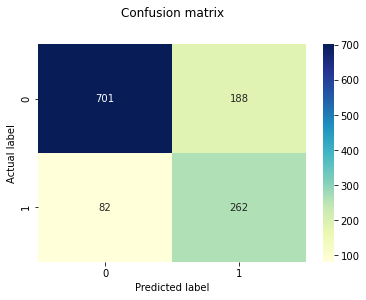

In [207]:
cm4 = confusion_matrix(y_val, y_pred_lgb)
p = sns.heatmap(pd.DataFrame(cm3), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
cm4 = confusion_matrix(y_val, y_pred_lgb)

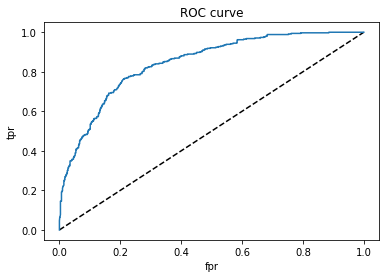

In [211]:
from sklearn.metrics import roc_curve
y_pred_proba = lgb_model4.predict_proba(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_lgb)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

### Se logra un mejor modelo con el ultimo ejercicio donde se controla el overfitting y se trata de minimizar los individuos que se predicen como no churn uy en realidad se van

In [208]:
#guardo el modelo final
models = {
    'LightGBM_final_con_smote': lgb_model4,
}

for name, model in models.items():
    joblib.dump(model, f'objetos/{name.replace(" ", "_")}_model.joblib')


In [214]:
importances = lgb_model4.feature_importances_
gain_importances = lgb_model4.booster_.feature_importance(importance_type='gain')
feature_names = X_train.columns
df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gain_importances
}).sort_values(by='Importance', ascending=False)

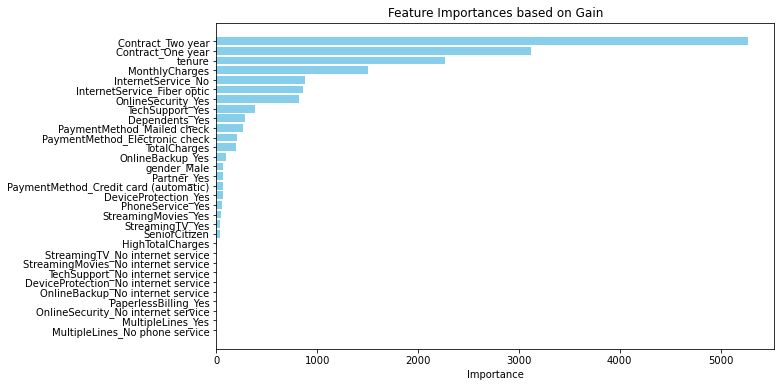

In [215]:
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances based on Gain')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()

### la varaible más importante Contrado de 2 años o de un año, el tiempo con la compañia de telecomunicaciones tal cual como se habia visto desde el análisis exploratorio y los cargos mensiales que a medida que aumentan se tienden a salir o retirar de la compañia.

lighgbm:
* Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, Tie-Yan Liu. “LightGBM: A Highly Efficient Gradient Boosting Decision Tree.” Advances in Neural Information Processing Systems 30 (NIPS 2017), pp. 3149-3157.

Regresión logística:
* sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Random forest:
sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Decision tree
* Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Optuna framework:
Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019.
Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD.
https://optuna.org/#paper

xgboost
* https://xgboost.readthedocs.io/en/stable/

Smote
* https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

Shap values
* https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
* https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html